$$ $$
  
<a id="contents"></a>

<center style ="font-size: x-large; font-weight: 600; line-height: 1.1;padding: 10px">
Bayesian Techniques to Improve the Electron Density Profile Reconstruction within a Tokamak   
First Try with Synthetic Data
</center>  
<center>
Daniel Jordan, Geert Verdoolaghe, Hao Wu
</center>
 
### Abstract:
<div style="text-align: justify; padding: 20px">Abstract goes here
</div>

#### Key words: Bayesian Inference, Nuclear Fusion, Interferometry
----
#### Collaboration between
<center>
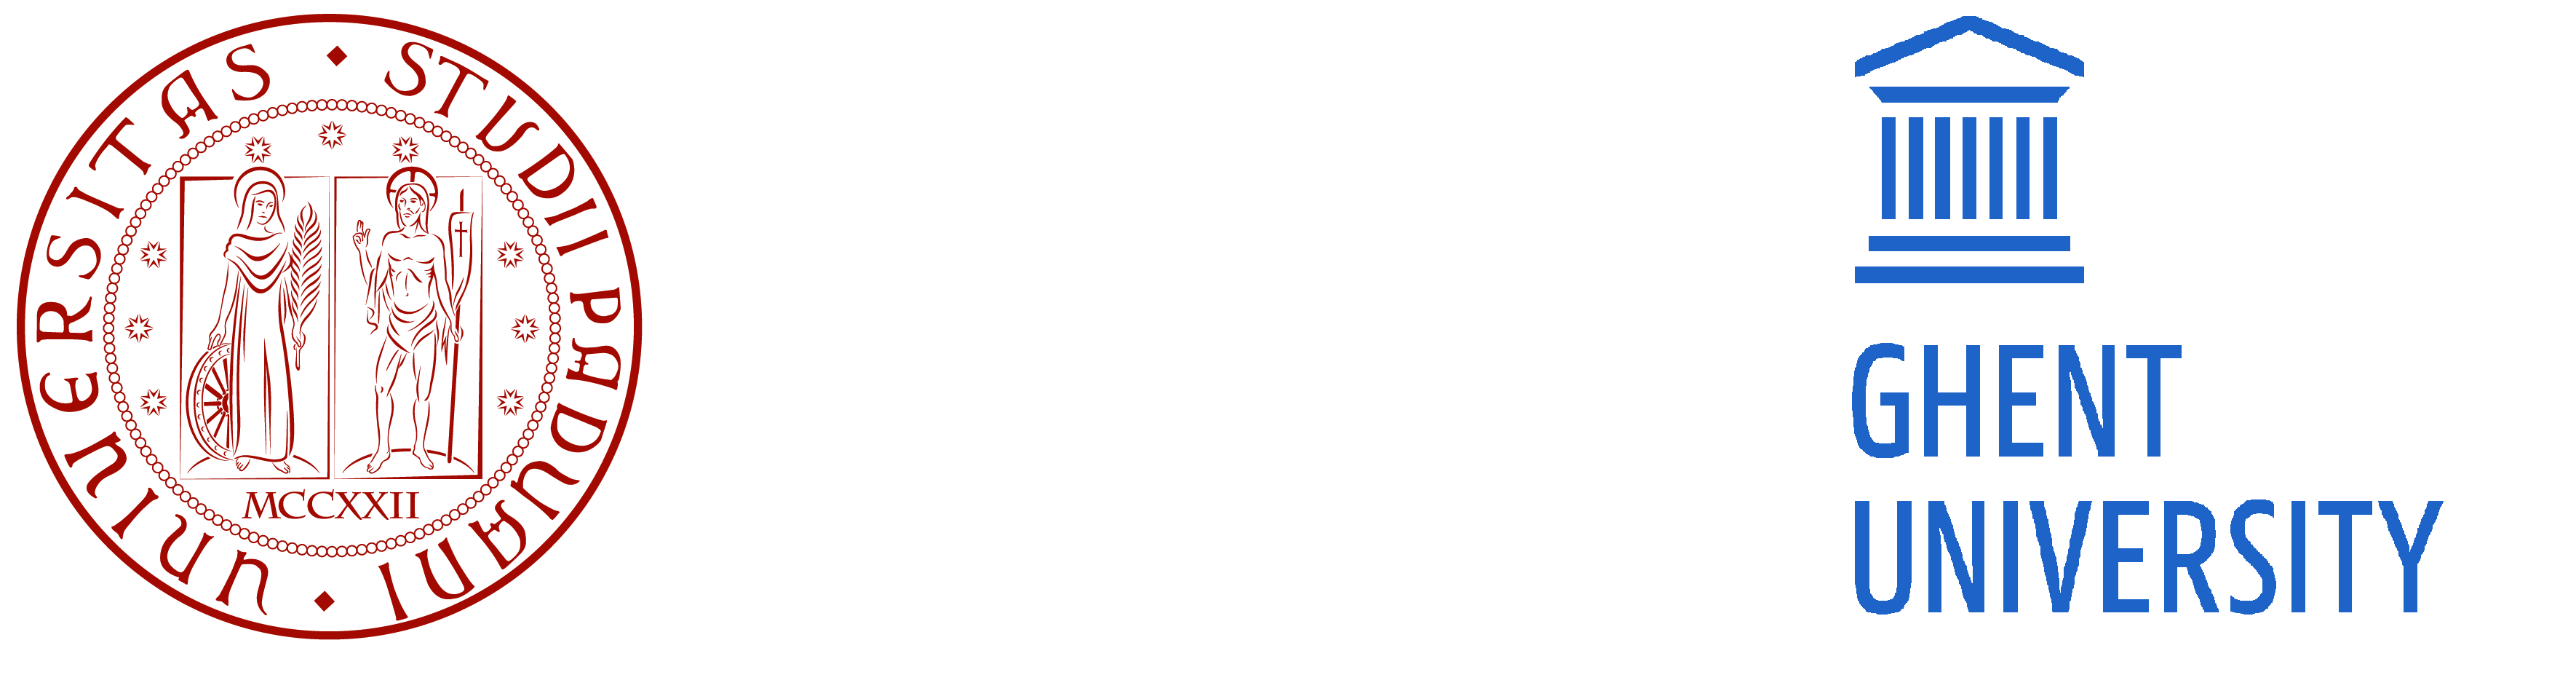
</center>


---
<a id="contents"></a>
## Contents 

* [Section 1: Introduction](#intro)
* [Section 2: Methodology](#method)
* [Section 3: Bayesian Experimental Design Implimentation](#design)  
  * [BED Effect of Sample Size](#samplesize)
  * [BED Full Design Parameter Space](#full)
  * [BED with Multiple Lines of Sight](#multiple)
  * [BED Many Laser Feasability](#feasability)
* [Section 4: Conclusion](#design)  


<a id="intro"></a>
# Section 1: Introduction
[Return to Contents](#contents)

INTRO

## Bayesian Inference

<a id="design"></a>
# Section 3: Bayesian Inference Implimentation
[Return to Contents](#contents)

#### DASK Local Cluster, set-up 
Dask is a powerful python tool for multitasking and scaling. It is in essance a task scheduler for clusters. The following code creates a local cluster of 8 virtual machines. This should be changed to reflect the number of cores available. This will allow for the dask API to be used to perform paralell operations. 

In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
n_cores = 4
cluster.scale(n_cores)
print(cluster.dashboard_link)
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/daniel/Improving-Electron-Density-Profile-Inference-within-a-Tokamak-using-Bayesian-Techniques/dask-worker-space/worker-btvdtw1e', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/daniel/Improving-Electron-Density-Profile-Inference-within-a-Tokamak-using-Bayesian-Techniques/dask-worker-space/worker-w6xzk3of', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/daniel/Improving-Electron-Density-Profile-Inference-within-a-Tokamak-using-Bayesian-Techniques/dask-worker-space/worker-ferxot30', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/daniel/Improving-Electron-Density-Profile-Inference-within-a-Tokamak-using-Bayesian-Techniques/dask-worker-space/worker-ys_nmsfk', purging


http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 6.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45851,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 6.96 GiB
Comm: tcp://127.0.0.1:42201,Total threads: 1
Dashboard: http://127.0.0.1:37061/status,Memory: 1.74 GiB
Nanny: tcp://127.0.0.1:35939,


In [224]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39325/status,
Dashboard: http://127.0.0.1:39325/status,Workers: 8
Total threads: 16,Total memory: 31.27 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34539,Workers: 8
Dashboard: http://127.0.0.1:39325/status,Total threads: 16
Started: 20 minutes ago,Total memory: 31.27 GiB
Comm: tcp://127.0.0.1:41365,Total threads: 2
Dashboard: http://127.0.0.1:33903/status,Memory: 3.91 GiB
Nanny: tcp://127.0.0.1:33043,


#### Interferometry Class
This class will set up the plasma model and control the design parameters.

In [28]:
from forward_2d_square import compute_cross_points, compute_all_chord_lengths, compute_response_matrix, map_profile_to_2d
import numpy as np
import matplotlib.pyplot as plt
from time import time, perf_counter
from scipy.stats import multivariate_normal
import dask.bag as db
import pickle
import seaborn as sn

from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna
from numpy.linalg import inv


class Interferometry(object):
    def __init__(self,ne_fun,N,exp_er_base=0.05):
        self.r = np.linspace(1.0, 2.0, 201)
        self.z = np.linspace(-0.5, 0.5, 201)
        self.R, self.Z = np.meshgrid(self.r, self.z)
        self.rho_1d = np.linspace(0.0, 1.0, N)
        self.rho_all = ((self.R - 1.5) ** 2 / 0.16 + self.Z ** 2 / 0.25)
        self.ne_fun = ne_fun
        self.a = 1
        self.dens_1d = ne_fun(self.a,self.rho_1d)
        self.start_angles = None
        self.end_angles = None
        self.num_los = 0
        self.exp_er_base = exp_er_base
        self.timer = {'start':0,'stop':0}
        self.response = None
        self.lid_true = None
        self.lid_data = None
        
    def time(self):
        print('time taken in seconds',self.timer['stop']-self.timer['start'])
        
    def set_angles(self, start_angles, end_angles):
        self.start_angles = start_angles
        self.end_angles = end_angles
        self.num_los = len(self.start_angles)
        cross_points = compute_cross_points(self.r, self.z, self.start_angles, self.end_angles)
        chord_lengths = compute_all_chord_lengths(self.r, self.z, cross_points)
        exclude_indices = np.where(self.rho_all.flatten() > 1)
        chord_lengths[:, exclude_indices] = 0  # Remove the points outside the plasma boundary
        self.response = compute_response_matrix(chord_lengths, self.rho_all.flatten(), self.rho_1d)
        lid = self.calculate_simulated_signals(dens_1d=self.dens_1d, with_exp_er=True)
        self.lid_true = lid[0]
        self.lid_data = lid[1]
    def calculate_simulated_signals(self, dens_1d, with_exp_er=False):
        """
        Given 1D density profile, calculate simulated signals

        :param dens_1d: 1D density profile
        :return: Expected line-integrated signals along the lines of sight
        """
        lid_ne = np.matmul(self.response, dens_1d)
        if (with_exp_er):
            lid_data = lid_ne + np.random.normal(loc=np.zeros(self.num_los),scale=self.exp_er_base)
            return lid_ne, lid_data
        return lid_ne

    def visualize(self,highlight=np.empty((0,0)),hc=[],hl=[],title='Interferometry Model',onlyDensity=False, figsize = (10, 4),show=True, getDensityAx=False, line_lbl='Line of Sight'):
        dens_2d = map_profile_to_2d(self.rho_1d, self.dens_1d, self.rho_all)
        channel = np.arange(1, self.num_los + 1)

        fig = plt.figure(figsize=figsize)
        grid = plt.GridSpec(4, 11, wspace=0.5, hspace=0.5)
        
        if not onlyDensity:
            ax1 = plt.subplot(grid[0:3, 0:6])
            ax2 = plt.subplot(grid[0:3, 6:10])
        else:
            ax1 = plt.subplot(grid[0:3, 0:10])
            
            
        # Plot 2-D electron density profile and the lines of sight
        cs = ax1.pcolormesh(self.R, self.Z, dens_2d, cmap='jet')#shading='auto')
        theta = np.linspace(0, np.pi * 2, 100)
        x_circle = 1.5 + 0.5 * np.cos(theta)
        y_circle = 0.5 * np.sin(theta)
        ax1.plot(x_circle, y_circle, 'r')
        def plt_line(start_angle, end_angle, color='k',leg=False,label=line_lbl):
            x_start = 1.5 + 0.5 * np.cos(start_angle)
            x_end = 1.5 + 0.5 * np.cos(end_angle)
            y_start = 0.5 * np.sin(start_angle)
            y_end = 0.5 * np.sin(end_angle)
            if leg==False:
                ax1.plot([x_start, x_end], [y_start, y_end], color)
            if leg==True:
                ax1.plot([x_start, x_end], [y_start, y_end], color,label=label)
            
        for i in range(self.num_los):
            if i==0:
                plt_line(self.start_angles[i],self.end_angles[i],leg=True)
            plt_line(self.start_angles[i],self.end_angles[i])
            
                    
            
        if len(highlight)!=0:
            i=0
            for h in highlight:
                plt_line(h[0],h[1],color=hc[i],leg=True,label=hl[i])
                i+=1
            
        ax1.set_aspect('equal')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_xlabel('R (m)')
        ax1.set_ylabel('Z (m)')
        ax1.set_title('Lines of Sight Across Electron Density Profile')
        ax1.legend(loc='lower right')
        cb = fig.colorbar(cs, ax=ax1, label=r'Electron Density, $n_e$, $10^{19}m^{-3}$')

        # Plot the line-integrated electron density for each LOS
        if not onlyDensity:
            ax2.scatter(channel, self.lid_true, label='Ground Truth')
            ax2.scatter(channel, self.lid_data, label='Synthetic Data')
            ax2.plot(channel, self.lid_true)
            ax2.set_xlabel('Line Number')
            tkpos = np.arange(1,self.num_los,np.round(self.num_los/10))
            vecInt = np.vectorize(int)
            tkpos = vecInt(tkpos)
            ax2.set_xticks(tkpos,tkpos)
            ax2.set_ylabel(r'Line Integrated Density, $10^{19}m^{-2}$')
            ax2.set_title('Simulation for each Line of Sight')
            ax2.legend()
            fig.suptitle(title,fontsize='x-large',fontweight='bold')
        if show: plt.show()
        if getDensityAx: return ax1
        
    # only needed for experimental design
    def draw_samples_calculate_eu(self, num_samples=1000, ml_samples=1000, dask=False):
        """
        Assume the density profile is given by a * (1 - rho^2). Draw samples from the joint distribution of a and data

        :param num_samples: Number of samples
        :return:
        """
#         self.samples = np.zeros((num_samples, 1+self.num_los+2))
        # Sample density profile coefficiant from uniform prior
        a = np.random.uniform(size=num_samples,low=0.5,high=1.5)
        dens_1d = [self.ne_fun(a_i, self.rho_1d) for a_i in a]
        #sample possible measurements for the samples plasma density profile
        lid_ne, lid_data = zip(*[self.calculate_simulated_signals(dens_1d_i, with_exp_er=True) for dens_1d_i in dens_1d])
        
        # likelihood
        likelihood = [multivariate_normal.pdf(lid_data_i, lid_ne_i, self.sigma) for lid_data_i,lid_ne_i in zip(lid_ne,lid_data)]
        
        self.timer['start'] = perf_counter()
        #marginal likelihood
        marginal_likelihood = []
        a2 = np.random.uniform(size=ml_samples,low=0.5,high=1.5)
        dens_1d2 = [self.ne_fun(a_i, self.rho_1d) for a_i in a2]
        lid_ne2 = [self.calculate_simulated_signals(dens_1d_i, with_exp_er=False) for dens_1d_i in dens_1d2]
        for i in range(num_samples):
            ml = []
            for j in range(ml_samples):
                ml.append(multivariate_normal.pdf(lid_data[i],lid_ne2[j], self.sigma))
            marginal_likelihood.append(np.mean(ml))
        self.timer['stop'] = perf_counter()
        
        expected_utility = np.mean([np.log(li/mli) for li,mli in zip(likelihood,marginal_likelihood)])
        return expected_utility

# The Ground Truth Electron Density Profile

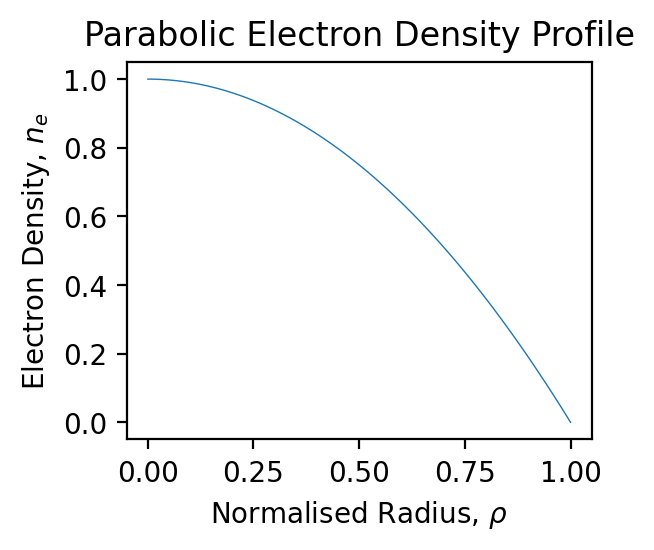

In [66]:
#Number of divisions of the ne profile
N = 100
def ne_parabolic(a,rho_1d):
    dens_1d = a*(1-rho_1d**2)
    return dens_1d
rho_1d = np.linspace(0,1,N)

figGT = plt.figure(figsize=(3,2.5))
plt.plot(rho_1d, ne_parabolic(1,rho_1d))
plt.title('Parabolic Electron Density Profile')
plt.xlabel(r'Normalised Radius, $\rho$')
plt.ylabel(r'Electron Density, $n_e$')
plt.show()

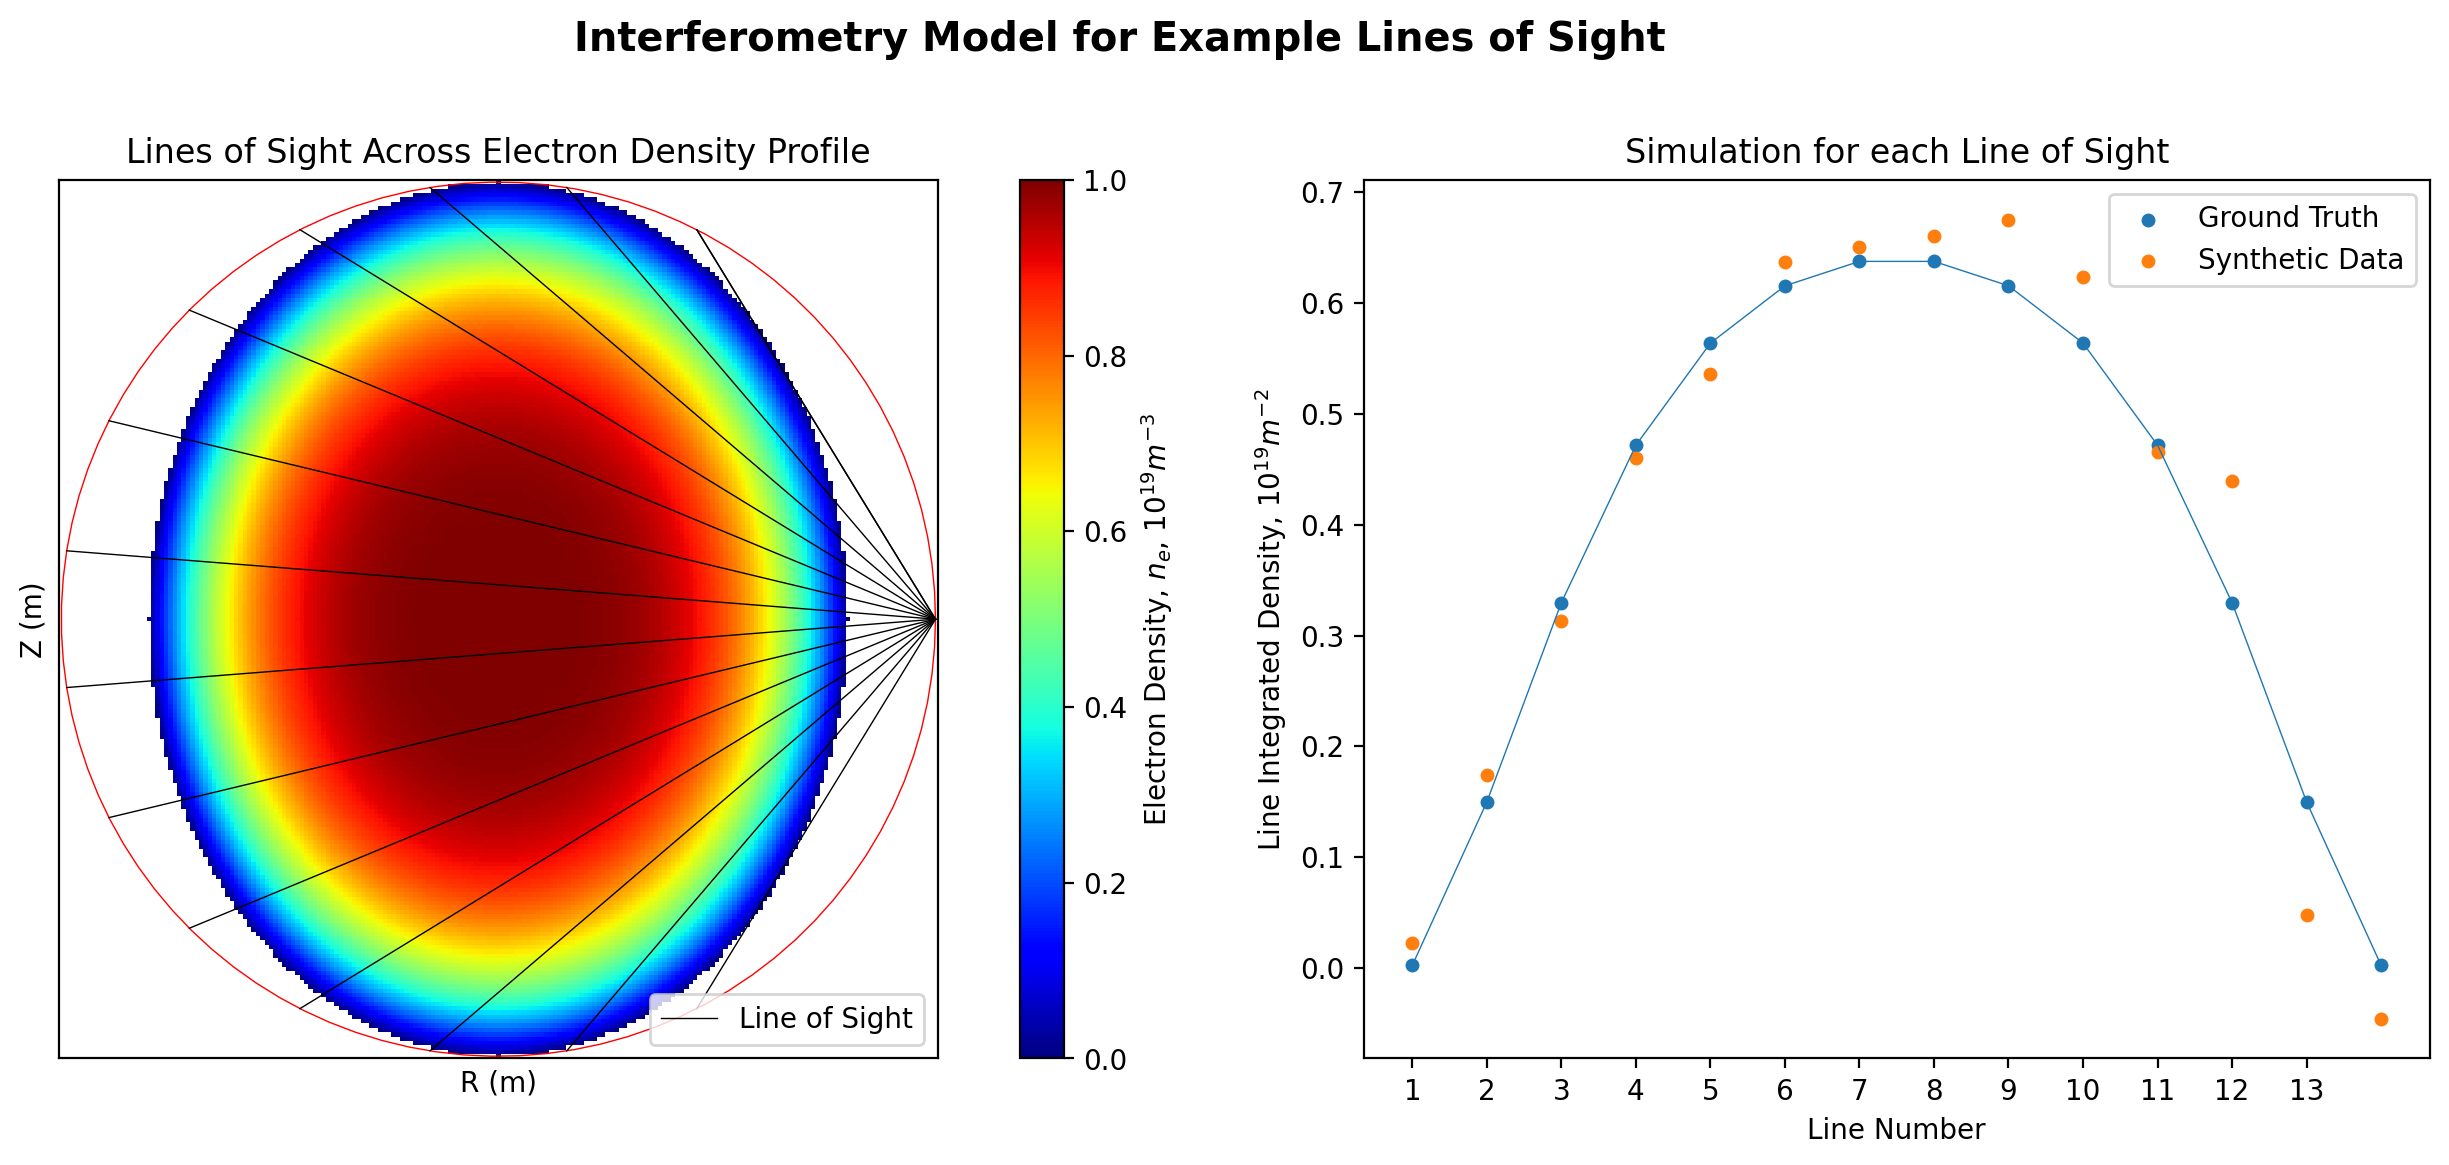

In [98]:
# from design import Interferometry
exp_er = 0.05
interf = Interferometry(ne_parabolic,N,exp_er)
div = 0.1*np.pi
angles = np.arange(0.35*np.pi,1.65*np.pi+div,div)
interf.set_angles(list(np.zeros(len(angles))),list(angles))
ax_density = interf.visualize(title = 'Interferometry Model for Example Lines of Sight', onlyDensity=False, figsize=(20,8), getDensityAx=True)

In [90]:
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

      fun: -7.968394333450017
 hess_inv: array([[0.89400399, 0.47597132],
       [0.47597132, 0.94729186]])
      jac: array([-4.17232513e-07,  5.36441803e-07])
  message: 'Optimization terminated successfully.'
     nfev: 66
      nit: 20
     njev: 22
   status: 0
  success: True
        x: array([1.0771697, 0.7534663])


Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 7.812499999999998e-10
The Determinent of cov_post3 is: 0.0


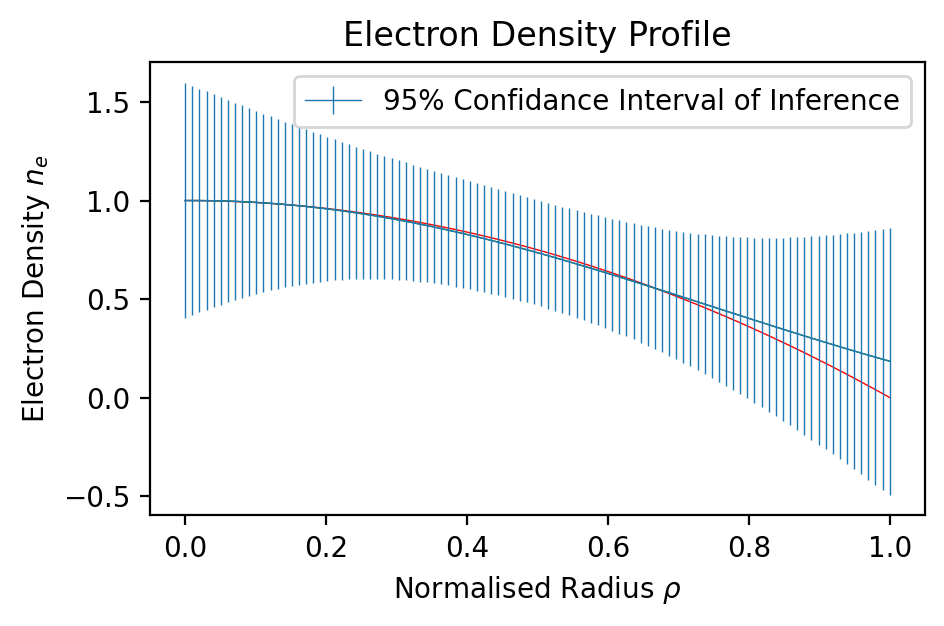

In [99]:
##Prior
mu_prior = np.zeros(N)
#exponential square kernel
def Kernel(rho1,rho2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((rho1-rho2)*(rho1-rho2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    rho1, rho2 = np.meshgrid(rho_1d,rho_1d)
    #covergence matrix of Prior
    K = Kernel(rho1,rho2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,interf.num_los))
    R = interf.response
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(interf.lid_data.T@chol_inv(cov_li+R@K@R.T)@interf.lid_data)                
    
x0=[0.76,0.01]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
print(results)
best_params = results.x
# best_params = x0

def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
#     print(K)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (interf.lid_data - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Electron Density Profile')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e$')
    plt.plot(rho_1d, ne_parabolic(1,rho_1d),'r')
    plt.plot(rho_1d, mu_post3,'g')
    plt.errorbar(rho_1d, mu_post3, yerr=error_bars3, label='95% Confidance Interval of Inference')
    plt.legend()
    plt.show()

PlotBest(best_params, exp_er)